# **EDA**
In the EDA (Exploratory Data Analysis) for the "homicidio" dataset, we will focus on aspects not covered in the etl.ipynb file. Since **missing values** and **duplicates** have already been addressed in the **ETL process**, in this phase we will **concentrate** on identifying and handling **outliers**, and **creating pertinent charts** for both *qualitative* and *quantitative* variables. This targeted approach will enhance our understanding of the dataset, which is essential for the *effective development and analysis of key performance indicators (KPIs)*.

In [92]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import fiona
from datetime import datetime
import calendar
import plotly.express as px
import geopandas as gpd
from shapely.geometry import Point
from shapely.wkt import loads

### Import and Review data

In [93]:
#Import the Dataframe
homicidios= pd.read_csv("data/total_homicidios.csv")
homicidios.head()

,Fecha,Año,Mes,Día,Rol,Víctima,Sexo,Edad,Fecha fallecimiento,N victimas,...,Tipo de calle,Calle,Dirección normalizada,Comuna,Xy (caba),Pos x,Pos y,Participantes,Acusado,Hora
0,2016-01-01,2016,1,1,CONDUCTOR,MOTO,MASCULINO,19,2016-01-01,1,...,AVENIDA,PIEDRA BUENA AV.,"PIEDRA BUENA AV. y FERNANDEZ DE LA CRUZ, F., G...",8,Point (98896.78238426 93532.43437792),-58.475340,-34.687570,MOTO-AUTO,AUTO,04:00:00
1,2016-01-02,2016,1,2,CONDUCTOR,AUTO,MASCULINO,70,2016-01-02,1,...,GRAL PAZ,"PAZ, GRAL. AV.","PAZ, GRAL. AV. y DE LOS CORRALES AV.",9,Point (95832.05571093 95505.41641999),-58.508775,-34.669777,AUTO-PASAJEROS,PASAJEROS,01:15:00
2,2016-01-03,2016,1,3,CONDUCTOR,MOTO,MASCULINO,30,2016-01-03,1,...,AVENIDA,ENTRE RIOS AV.,ENTRE RIOS AV. 2034,1,Point (106684.29090040 99706.57687843),-58.390403,-34.631894,MOTO-AUTO,AUTO,07:00:00
3,2016-01-10,2016,1,10,CONDUCTOR,MOTO,MASCULINO,18,NaN,1,...,AVENIDA,LARRAZABAL AV.,"LARRAZABAL AV. y VILLEGAS, CONRADO, GRAL.",8,Point (99840.65224780 94269.16534422),-58.465039,-34.680930,MOTO-SD,SD,00:00:00
4,2016-01-21,2016,1,21,CONDUCTOR,MOTO,MASCULINO,29,2016-02-01,1,...,AVENIDA,SAN JUAN AV.,"SAN JUAN AV. y SAENZ PEÃ‘A, LUIS, PRES.",1,Point (106980.32827929 100752.16915795),-58.387183,-34.622466,MOTO-PASAJEROS,PASAJEROS,05:20:00


## **Quantitative & Qualitative Categories of `Homicidios`  Data**
We create a dataset that categorizes traffic incident data in Buenos Aires into quantitative and qualitative types. Quantitative columns (like "Year", "Month", "Number of Victims") provide numerical data essential for trend analysis and statistical calculations. Qualitative columns (such as "Tipo de calle", "Rol", "Género") offer descriptive information crucial for contextual understanding. Accurate categorization is key for effective data visualization and informs traffic safety policies.

In [94]:
# Display a concise summary of the 'homicidios' DataFrame, including the number of non-null entries per column, the datatype of each column, and memory usage.
homicidios.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 717 entries, 0 to 716
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Fecha                  717 non-null    object 
 1   Año                    717 non-null    int64  
 2   Mes                    717 non-null    int64  
 3   Día                    717 non-null    int64  
 4   Rol                    717 non-null    object 
 5   Víctima                717 non-null    object 
 6   Sexo                   717 non-null    object 
 7   Edad                   717 non-null    object 
 8   Fecha fallecimiento    648 non-null    object 
 9   N victimas             717 non-null    int64  
 10  Hh                     717 non-null    int64  
 11  Lugar del hecho        717 non-null    object 
 12  Tipo de calle          717 non-null    object 
 13  Calle                  716 non-null    object 
 14  Dirección normalizada  708 non-null    object 
 15  Comuna

Now, we are going to analize every column and check the `class` and `category` and create a dataframe with that information

In [95]:
# Información de las columnas del nuevo dataset proporcionado
new_columns_info = {
    "Fecha": ["Date in format dd/mm/yyyy", "object", "Quantitative", "Discrete"],
    "Año": ["Year", "int64", "Quantitative", "Discrete"],
    "Mes": ["Month", "int64", "Quantitative", "Discrete"],
    "Día": ["Day of the month", "int64", "Quantitative", "Discrete"],
    "Rol": ["Role in the incident", "object", "Qualitative", "Nominal"],
    "Víctima": ["Type of Victim in the incident", "object", "Qualitative", "Nominal"],
    "Sexo": ["Gender", "object", "Qualitative", "Nominal"],
    "Edad": ["Age", "object", "Quantitative", "Discrete"],  
    "Fecha fallecimiento": ["Date of death", "object", "Quantitative", "Discrete"],
    "N victimas": ["Number of victims", "int64", "Quantitative", "Discrete"],
    "Hh": ["whole time slot (INT)", "object", "Quantitative", "Discrete"],
    "Lugar del hecho": ["Location of the incident", "object", "Qualitative", "Nominal"],
    "Tipo de calle": ["Type of street", "object", "Qualitative", "Nominal"],
    "Calle": ["Street name where the incident occurred", "object", "Qualitative", "Nominal"],
    "Dirección normalizada": ["Normalized address", "object", "Qualitative", "Nominal"],
    "Comuna": ["Commune of the city", "int64", "Qualitative", "Nominal"],  #The name of the comuna is expressed in numbers
    "Xy (caba)": ["Flat geocoding", "object", "Quantitative", "Continuous"],
    "Pos x": ["Longitude with a dot as the separator. WGS84", "object", "Quantitative", "Continuous"],
    "Pos y": ["Latitude with a dot as the separator. WGS84", "object", "Quantitative", "Continuous"],
    "Participantes": ["Participants in the incident", "object", "Qualitative", "Nominal"],
    "Acusado": ["Accused in the incident", "object", "Qualitative", "Nominal"],
    "Hora": ["Time of the incident", "object", "Quantitative", "Continuous"]
}

# Crear DataFrame a partir de la nueva información
df_new_columns_description = pd.DataFrame.from_dict(new_columns_info, orient='index', columns=["Description", "Dtype", "Class", "Category"])

# Resetear el índice para incluir el nombre de la columna como una columna regular
df_new_columns_description.reset_index(inplace=True)
df_new_columns_description.rename(columns={'index': 'Column Name'}, inplace=True)

df_new_columns_description.head(22)  # Mostrar las 22 filas del DataFrame generado

,Column Name,Description,Dtype,Class,Category
0,Fecha,Date in format dd/mm/yyyy,object,Quantitative,Discrete
1,Año,Year,int64,Quantitative,Discrete
2,Mes,Month,int64,Quantitative,Discrete
3,Día,Day of the month,int64,Quantitative,Discrete
4,Rol,Role in the incident,object,Qualitative,Nominal
5,Víctima,Type of Victim in the incident,object,Qualitative,Nominal
6,Sexo,Gender,object,Qualitative,Nominal
7,Edad,Age,object,Quantitative,Discrete
8,Fecha fallecimiento,Date of death,object,Quantitative,Discrete
9,N victimas,Number of victims,int64,Quantitative,Discrete


### **Qualitative Variables**

In [96]:
#Let's filter the `Qualitative` Variables
qual = df_new_columns_description[df_new_columns_description['Class'] == 'Qualitative']
qual.head(10)

,Column Name,Description,Dtype,Class,Category
4,Rol,Role in the incident,object,Qualitative,Nominal
5,Víctima,Type of Victim in the incident,object,Qualitative,Nominal
6,Sexo,Gender,object,Qualitative,Nominal
11,Lugar del hecho,Location of the incident,object,Qualitative,Nominal
12,Tipo de calle,Type of street,object,Qualitative,Nominal
13,Calle,Street name where the incident occurred,object,Qualitative,Nominal
14,Dirección normalizada,Normalized address,object,Qualitative,Nominal
15,Comuna,Commune of the city,int64,Qualitative,Nominal
19,Participantes,Participants in the incident,object,Qualitative,Nominal
20,Acusado,Accused in the incident,object,Qualitative,Nominal


#### **Victim Role**

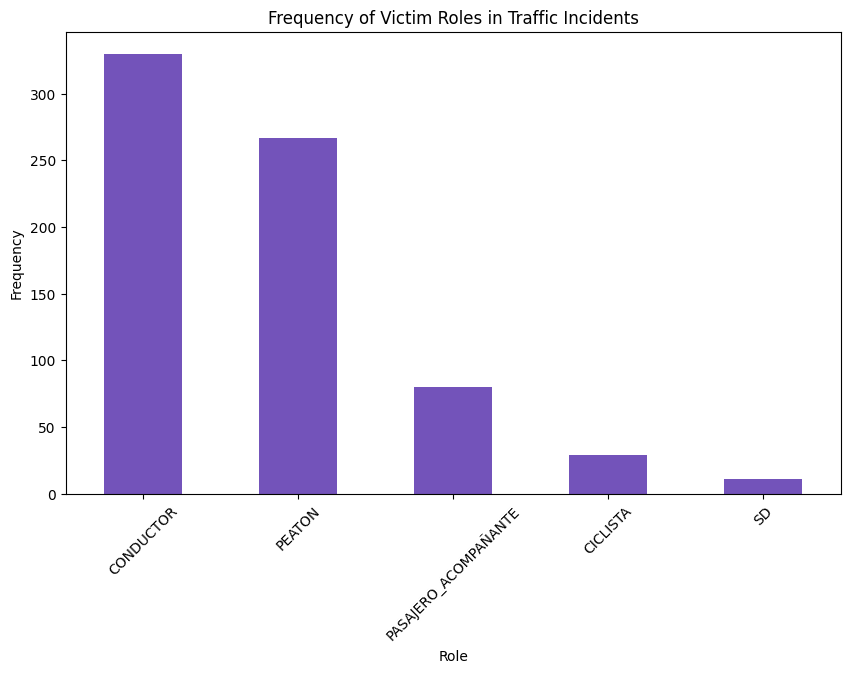

In [97]:
# We create a frequency table for the 'Role' column
frequency_table = homicidios['Rol'].value_counts()

# We plot this as a bar chart
frequency_table.plot(kind='bar', color="#7353ba", figsize=(10, 6))
plt.title('Frequency of Victim Roles in Traffic Incidents')
plt.xlabel('Role')
plt.ylabel('Frequency')
plt.xticks(rotation=45)  # Rotate the labels for better readability
plt.show() 

This bar chart presents the frequency of roles in traffic incidents. It is evident that `CONDUCTOR` *(driver)* and `PEATON` *(pedestrian)* are the most commonly reported roles, highlighting them as the most at-risk groups. The lower occurrence of `PASAJERO ACOMPAÑANTE` *(passenger/companion)* and `CICLISTA` *(cyclist)* roles suggests they are less frequently involved. The `SD` category indicates cases with unspecified data. Focusing on drivers and pedestrians could be key for improving traffic safety measures.

#### **Víctim Type**

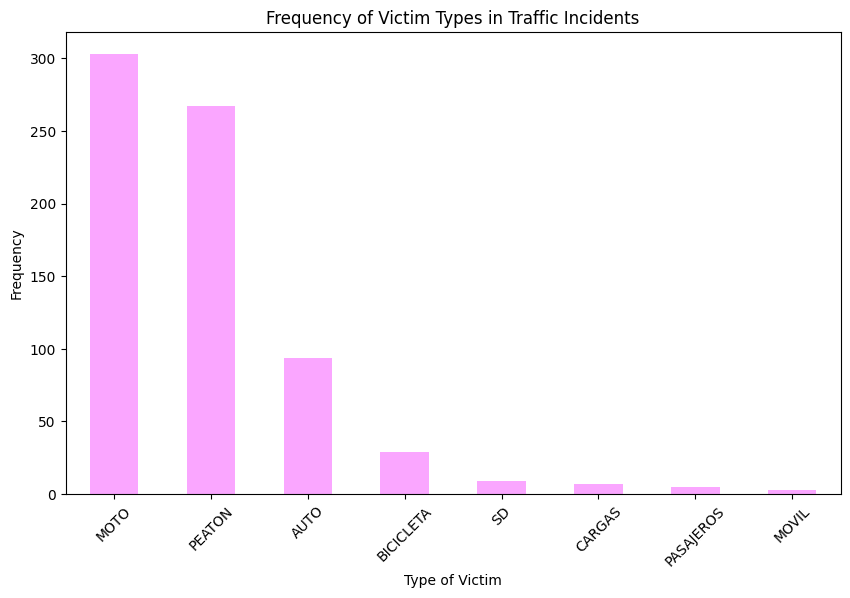

In [98]:
# Create a frequency table for the 'Víctima' column
victim_frequency = homicidios['Víctima'].value_counts()

# Plot this data as a bar chart using the specified color
ax = victim_frequency.plot(kind='bar', color="#faa6ff", figsize=(10, 6))

# Set the title and labels in English
plt.title('Frequency of Victim Types in Traffic Incidents')
plt.xlabel('Type of Victim')
plt.ylabel('Frequency')

# Rotate the x-axis labels to be horizontal for better readability
plt.xticks(rotation=45)

# Display the plot
plt.show()

The bar chart **"Frequency of Victim Types in Traffic Incidents"** shows that *pedestrians* and *motorcyclists* are the **most common victims** in traffic incidents, significantly outnumbering those in cars, bicycles, and other categories. This highlights the need for focused safety measures for these vulnerable road users.

#### **Gender in Traffic Incidents**

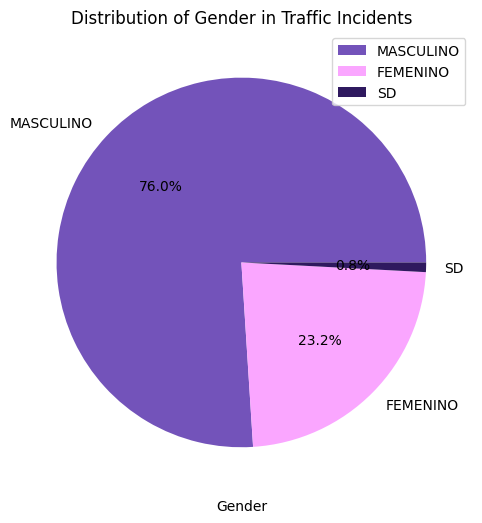

In [99]:
# Create a gender table for the Sexo column
Sexo = homicidios['Sexo'].value_counts()

# Plot this as a pie chart
Sexo.plot(kind='pie', colors=["#7353ba","#faa6ff","#2f195f",], figsize=(10, 6), autopct='%1.1f%%')
plt.title('Distribution of Gender in Traffic Incidents')
plt.xlabel('Gender')
plt.ylabel('')
plt.legend(labels=Sexo.index, loc="upper right")
plt.show()

The pie chart **"Distribution of Gender in Traffic Incidents"** illustrates that a significant majority of traffic incident victims in Buenos Aires are `male` (76.0%) by far, with `female` victims comprising 23.2%. A negligible percentage is unspecified (0.8%). This data could be pivotal in tailoring gender-specific road safety campaigns and interventions.

#### **Type of street in Traffic Incidents**

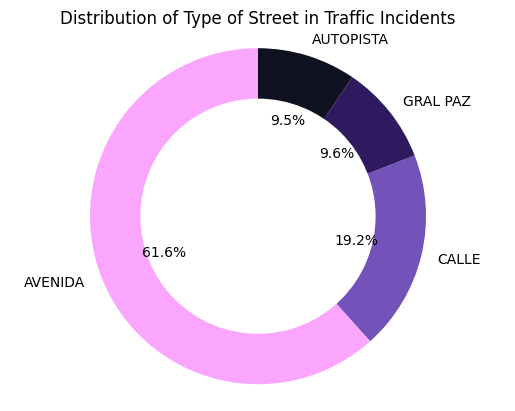

In [100]:
# Count the frequency of each 'Tipo de calle'
street_type_counts = homicidios['Tipo de calle'].value_counts(normalize=True) * 100

# Define the color palette for the donut chart
colors = ['#faa6ff', '#7353ba', '#2f195f', '#0f1020', '#efc3f5', '#a64ca6', '#660066', '#a8a8a8', '#707070']

# Create the donut chart
fig, ax = plt.subplots()
ax.pie(street_type_counts, labels=street_type_counts.index, autopct='%1.1f%%', startangle=90, colors=colors)
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig.gca().add_artist(centre_circle)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Distribution of Type of Street in Traffic Incidents')

# Show the plot
plt.show()

The donut chart chart **"Frequency of Type of Street in Traffic Incidents"** indicates that `AVENIDA` **(avenues)** are the most common sites for traffic incidents, followed by `CALLE` **(streets)**, with `GRAL PAZ` and `AUTOPISTA` **(highways)** having notably fewer occurrences. This suggests avenues are critical areas to focus on for traffic safety improvements in Buenos Aires.

Given the high incidence on avenues, it is recommended that the city of Buenos Aires focuses on improving road safety measures on these thoroughfares. This could include enhanced signage, better pedestrian crossings, and targeted enforcement of traffic laws to reduce accidents and improve overall traffic safety in the area.

#### **Commune of the city**

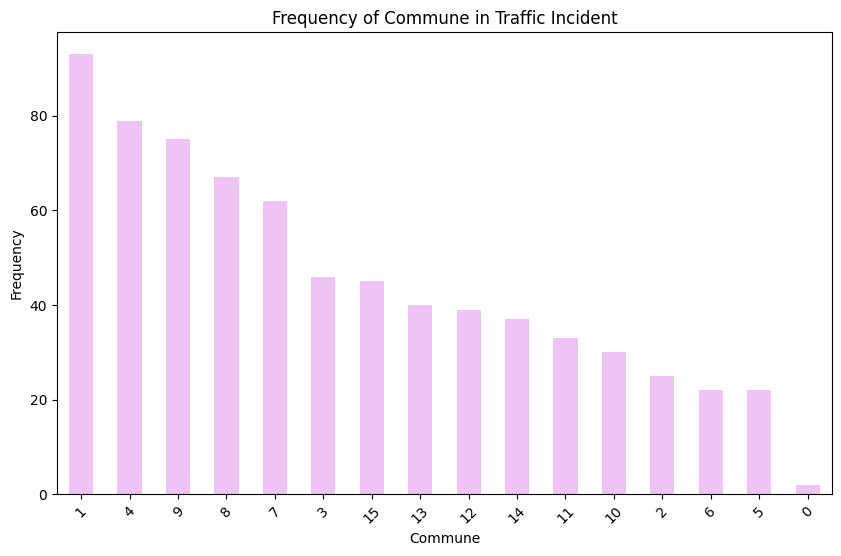

In [101]:
# We create a comuna table for the 'Comuna' column
comuna = homicidios['Comuna'].value_counts()

# We plot this as a bar chart
comuna.plot(kind='bar', color="#efc3f5", figsize=(10, 6))
plt.title('Frequency of Commune in Traffic Incident')
plt.xlabel('Commune')
plt.ylabel('Frequency')
plt.xticks(rotation=45)  # Rotate the labels for better readability
plt.show()

The bar chart illustrates **traffic incident frequencies** in Buenos Aires communes, with *Commune 1* reporting the most incidents, closely followed by *Communes 4, 9, 8, and 7*. These areas may benefit from targeted traffic safety and control measures. It's recommended to prioritize these high-frequency communes for road safety audits and interventions. 'Commune 0' denotes incidents with unspecified locations.

#### **Distribution of Accused in Accidents**

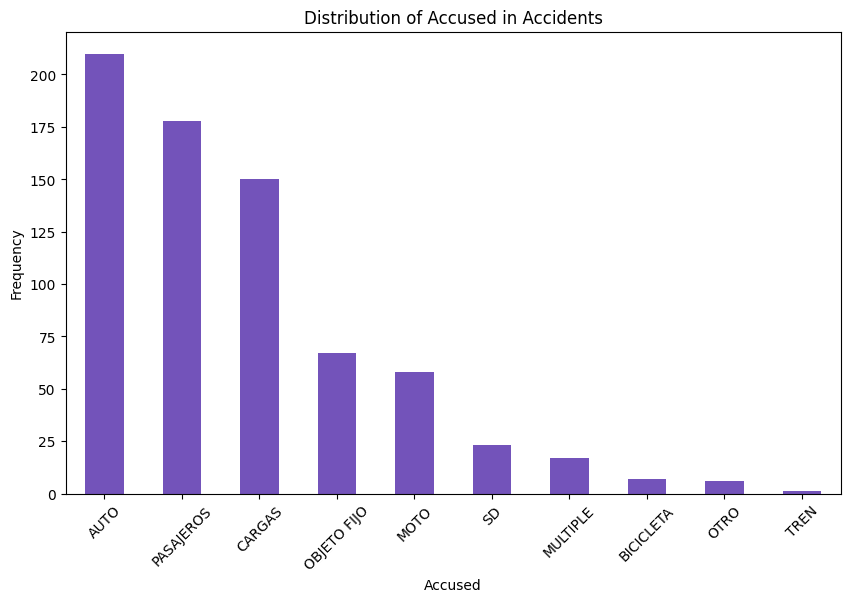

In [102]:
# We create a accused table for the 'Acusado' column
acussed = homicidios['Acusado'].value_counts()

# We plot this as a bar chart
acussed.plot(kind='bar', color="#7353ba", figsize=(10, 6))
plt.title('Distribution of Accused in Accidents')
plt.xlabel('Accused')
plt.ylabel('Frequency')
plt.xticks(rotation=45)  # Rotate the labels for better readability
plt.show()

The bar chart **"Distribution of Accused in Accidents"** depicts that the majority of accusations in traffic incidents involve car drivers (`AUTO`), followed by passengers (`PASAJEROS`) and cargo vehicles (`CARGAS`). Motorcycles (`MOTO`) and unspecified (`SD`) sources are less frequently accused, with even fewer incidents involving multiple parties (`MULTIPLE`), bicycles (`BICICLETA`), others (`OTRO`), and trains (`TREN`). The data suggest a need for driver-focused safety campaigns and stricter enforcement of traffic laws for car drivers to reduce their involvement in accidents.

#### **Victim Role Distribution by Gender for Homicide Cases**

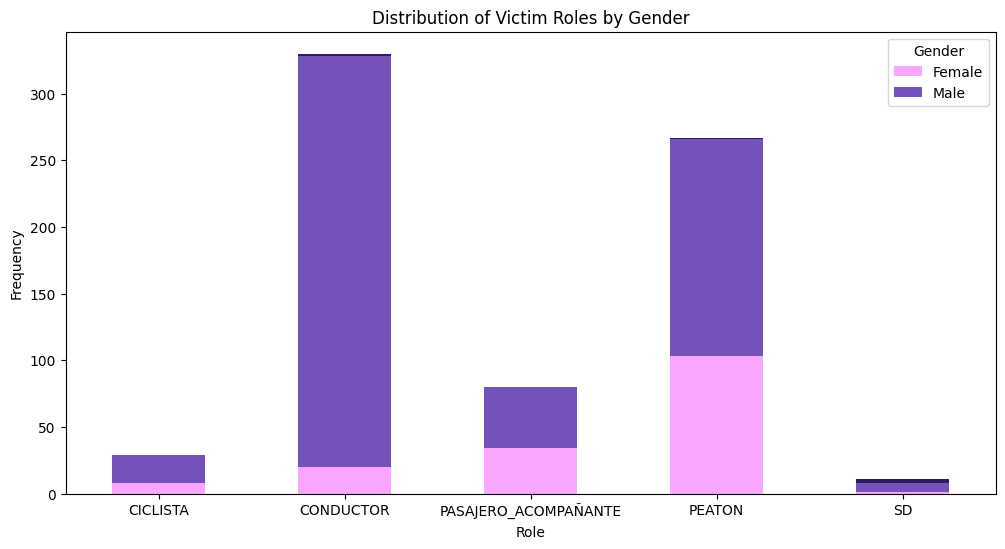

In [103]:
# Create a contingency table
role_gender = pd.crosstab(homicidios['Rol'], homicidios['Sexo'])

# Create a stacked bar chart
ax = role_gender.plot(kind='bar', stacked=True, figsize=(12, 6), 
                            color=["#faa6ff", "#7353ba", "#2f195f", "#0f1020"])

# Set the title and labels in English
plt.title('Distribution of Victim Roles by Gender')
plt.xlabel('Role')
plt.ylabel('Frequency')

# Add a legend with English terms
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles=handles, labels=['Female', 'Male'], title='Gender')

# Rotate the x-axis labels to be horizontal
plt.xticks(rotation=0)

# Display the plot
plt.show()

The chart before us displays the distribution of **roles among victims of vehicular accidents by gender**. We can observe that the role of `Conductor` or driver has the highest frequency for both male and female victims, indicating that **drivers are most often involved in fatal traffic incidents**. Following the drivers, `PEATON` or pedestrians represent the second most common victims, which underscores the vulnerability of pedestrians in traffic accidents. The roles of `Pasajero`, meaning passengers, and `CICLISTA`, cyclists, also appear, but to a lesser extent. Notably, there is a segment labeled `SD`, which likely stands for 'Sin Datos' or 'no data', indicating incidents where the victim's role was not identified. This kind of analysis is crucial in understanding the dynamics of traffic incidents and shaping preventative measures to enhance road safety, particularly in high-density cities like Buenos Aires where traffic incidents significantly impact public health and safety.

### **Quantitative Variables**

In [104]:
#Let's filter the `Quantitative` Variables
qual = df_new_columns_description[df_new_columns_description['Class'] == 'Quantitative']
qual.head(12)

,Column Name,Description,Dtype,Class,Category
0,Fecha,Date in format dd/mm/yyyy,object,Quantitative,Discrete
1,Año,Year,int64,Quantitative,Discrete
2,Mes,Month,int64,Quantitative,Discrete
3,Día,Day of the month,int64,Quantitative,Discrete
7,Edad,Age,object,Quantitative,Discrete
8,Fecha fallecimiento,Date of death,object,Quantitative,Discrete
9,N victimas,Number of victims,int64,Quantitative,Discrete
10,Hh,whole time slot (INT),object,Quantitative,Discrete
16,Xy (caba),Flat geocoding,object,Quantitative,Continuous
17,Pos x,Longitude with a dot as the separator. WGS84,object,Quantitative,Continuous


#### **Temporal Distribution of Number of Victims and its Relationship with Time**

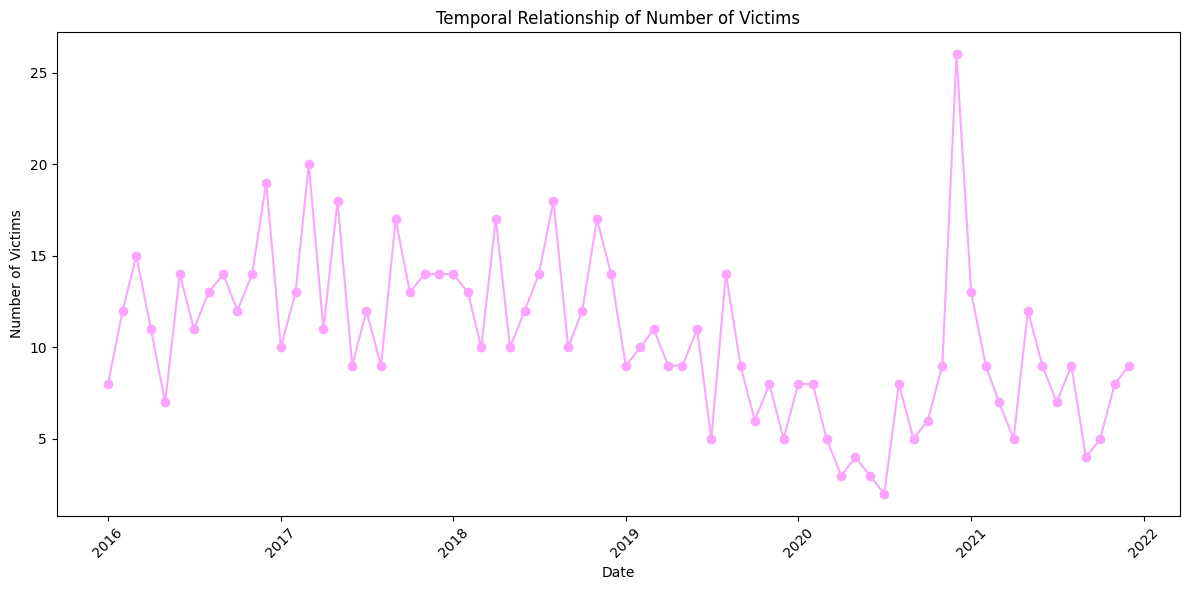

In [105]:
# Group by year and month, and sum the number of victims
time_relation = homicidios.groupby(['Año', 'Mes'])['N victimas'].sum().reset_index()

# Combine YEAR and MONTH to create a single time variable, creating the "Date" column as a string
time_relation["Date"] = time_relation["Año"].astype(str) + '-' + time_relation["Mes"].astype(str)

# Convert the time variable to datetime format
time_relation["Date"] = pd.to_datetime(time_relation["Date"])

# Sort the DataFrame by date to ensure chronological order
time_relation = time_relation.sort_values("Date")

# Create the line chart
plt.figure(figsize=(12, 6))
plt.plot(time_relation["Date"], time_relation["N victimas"], marker='o', color='#faa6ff')

# Add titles and labels
plt.title('Temporal Relationship of Number of Victims')
plt.xlabel('Date')
plt.ylabel('Number of Victims')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Display the chart
plt.tight_layout()
plt.show()


The peak observed in **December 2020** on the line chart could potentially be related to the unique circumstances of the COVID-19 pandemic. During this time, many regions experienced changes in traffic patterns due to lockdowns, restrictions, and alterations in public behavior. It's possible that the peak reflects a temporary increase in incidents as restrictions were lifted, or it could be associated with other factors such as year-end holidays. To confirm this, one would need to consider local policies, mobility reports, and public health measures in place during that time in Buenos Aires.

#### Monthly Distribution of Fatal Victims
A bar chart is generated to display the count of victims per month

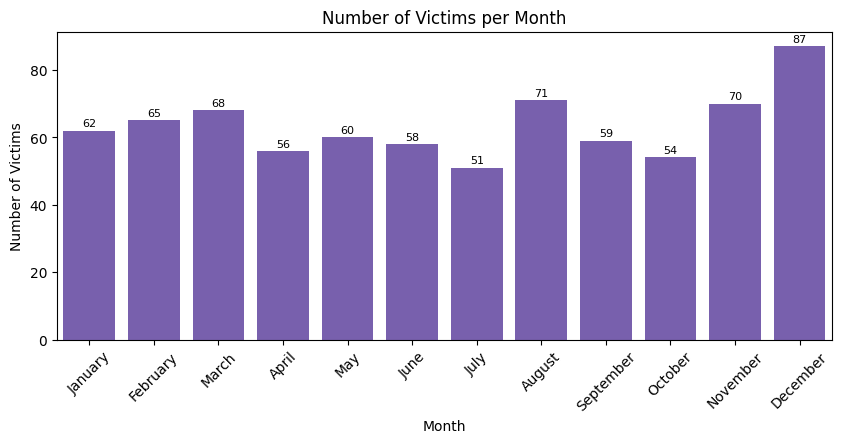

In [106]:
# Grouping by the number of victims per month
data = homicidios.groupby(['Mes'])['N victimas'].sum().reset_index()

# Mapping month numbers to month names
data["Mes"] = data["Mes"].apply(lambda x: calendar.month_name[x])

# Plotting
plt.figure(figsize=(10, 4))

ax = sns.barplot(x='Mes', y='N victimas', data=data, color="#7353ba")
ax.set_title('Number of Victims per Month')
ax.set_xlabel('Month')
ax.set_ylabel('Number of Victims')

# Adding victim count labels on each bar
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=8, color='black', xytext=(0, 5),
                textcoords='offset points')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Display the chart
plt.show()

The bar chart titled **"Number of Victims per Month"** shows the distribution of traffic incident victims over different months. The data, drawn from road traffic incidents in Buenos Aires (CABA), reveals a relatively consistent number of victims from January through March, with a slight increase in March. A noticeable dip occurs in July, which might correlate with seasonal changes or public holidays affecting traffic patterns. December sees a significant peak, which could be due to increased holiday traffic. The chart suggests that specific months, especially December, may require enhanced traffic management and safety measures to mitigate the higher incidence of traffic-related casualties.

#### **Time Slot**

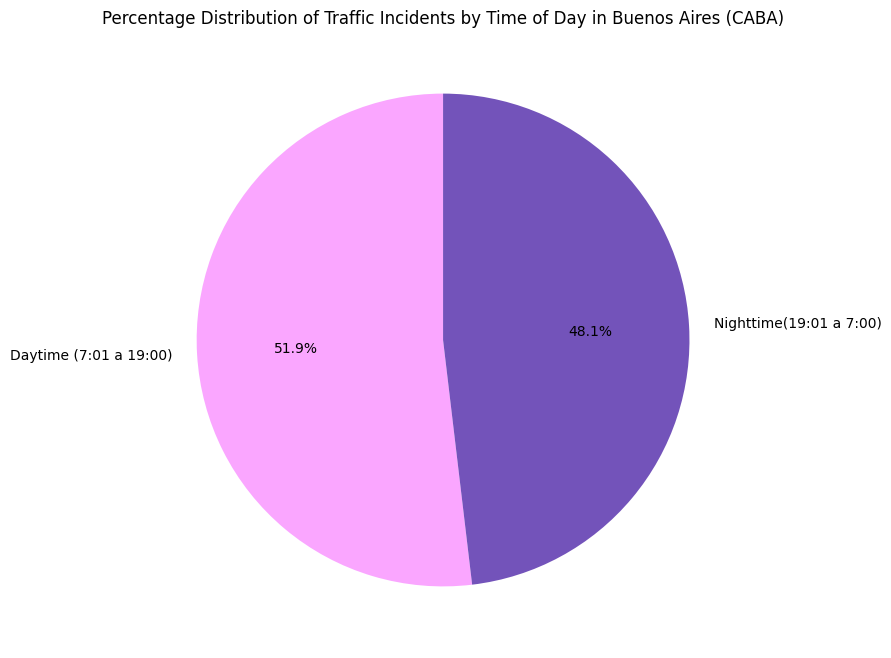

In [107]:
# Define day and night time based on hour
daytime_start = 7
daytime_end = 19

# Categorize time into 'Daytime', 'Nighttime', or 'Unknown'
homicidios['Time of Day'] = homicidios['Hh'].apply(
    lambda x: 'Daytime (7:01 a 19:00)' if daytime_start <= x < daytime_end else (
        'Nighttime(19:01 a 7:00)' if x >= daytime_end or x < daytime_start else 'Unknown')
)

# Count the frequency for each time of day
time_of_day_counts = homicidios['Time of Day'].value_counts()

# Calculate the percentage of incidents for each time of day
time_of_day_percentage = (time_of_day_counts / time_of_day_counts.sum()) * 100

# Plotting the pie chart
plt.figure(figsize=(8, 8))
time_of_day_percentage.plot(kind='pie', colors=['#faa6ff', '#7353ba', '#2f195f'], autopct='%1.1f%%', startangle=90)
plt.title('Percentage Distribution of Traffic Incidents by Time of Day in Buenos Aires (CABA)')
plt.ylabel('')  # Hide the y-axis label for better appearance
plt.show()

#### **Number of Accidents per hour**

In [108]:
# Create the histogram
accidents_hour = px.histogram(homicidios, x="Hh")

# Set the range of values on the X-axis from 0 to 24 and show every hour
accidents_hour.update_xaxes(
    title_text="Hours",
    tickmode='linear',  # Ensures the ticks are placed linearly
    dtick=1,  # Sets the interval of the tick marks
    range=[-0.5, 23.5]  # Sets the range to show a little before 0 and after 24 for better visibility
)

accidents_hour.update_yaxes(
    title_text="Frequency"  
)

# Show the histogram
accidents_hour.show()

Analyzing this graph, it’s evident that the number of accidents in Buenos Aires fluctuates throughout the day. The accidents peak at around 5-6 AM and then again at 2 PM. There is a significant drop in accidents during the late morning hours and a slight increase during the evening. This could be attributed to various factors such as traffic volume, visibility conditions, and human factors like alertness levels. The early morning peak might be due to reduced visibility or increased fatigue among drivers, while the afternoon peak could be associated with increased traffic volume. It’s important to note that these are just potential explanations and further investigation would be needed to confirm these hypotheses.

#### **Accident for type of Street and Victim**

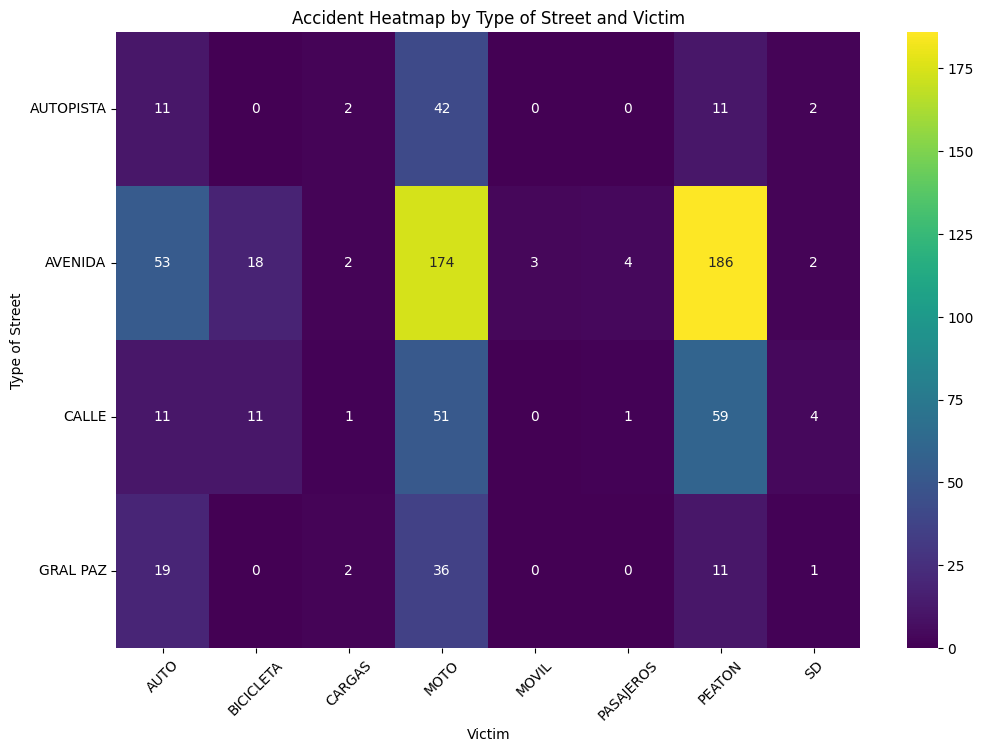

In [109]:
# Create a crosstab between 'Tipo de calle' and 'Víctima'
heatmap_data = pd.crosstab(homicidios['Tipo de calle'], homicidios['Víctima'])

# Plot a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, fmt="d", cmap='viridis')
plt.title('Accident Heatmap by Type of Street and Victim')
plt.xlabel('Victim')
plt.ylabel('Type of Street')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

From this heatmap, it's evident that avenues (`AVENIDA`) are particularly hazardous for motorcyclists and pedestrians, showing the highest incidents. This suggests a critical need for targeted safety measures on these streets. Highways (`AUTOPISTA`) also show a notable number of incidents involving vehicles, which could indicate a need for better enforcement of traffic laws. The data underscores the importance of focusing safety improvements on avenues and highways to reduce traffic-related injuries and fatalities in Buenos Aires (CABA).

#### **Number of victims by day of the week**

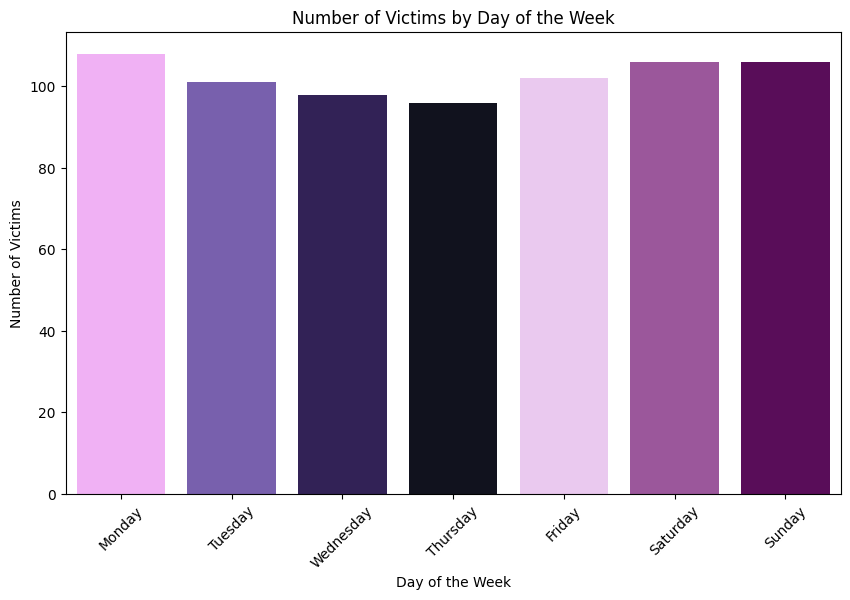

In [110]:
# Convert 'Fecha' to datetime to extract the day of the week
homicidios['Fecha'] = pd.to_datetime(homicidios['Fecha'], errors='coerce')
homicidios['Day of the Week'] = homicidios['Fecha'].dt.day_name()

# Define the order of the days for plotting
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

# Make sure 'Day of the Week' is a categorical type with the days in the desired order
homicidios['Day of the Week'] = pd.Categorical(homicidios['Day of the Week'], categories=day_order, ordered=True)

# Expanded color palette
colors = ["#faa6ff", "#7353ba", "#2f195f", "#0f1020", "#efc3f5", "#a64ca6", "#660066"]

# Create a count plot with 'Day of the Week' as both x and hue to avoid deprecation warning
plt.figure(figsize=(10, 6))
sns.countplot(data=homicidios, x='Day of the Week', hue='Day of the Week', palette=colors, dodge=False)
plt.title('Number of Victims by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Victims')
plt.legend([],[], frameon=False)  # Hide legend by passing empty lists
plt.xticks(rotation=45)
plt.show()

The bar chart **"Number of Victims by Day of the Week"** illustrates the frequency of traffic incident victims for each day in Buenos Aires (CABA). It is noticeable that the number of victims is fairly **consistent across the week**, with no single day showing a dramatic increase or decrease. This suggests that the risk of traffic incidents is relatively stable throughout the week, without a specific weekday being significantly more dangerous than the others.

In conclusion, as a data analyst reviewing this information, I would recommend that traffic safety measures in Buenos Aires be maintained with consistent vigilance every day of the week, since there's no marked decrease in risk on any given day. This could include regular patrols, ongoing public safety announcements, and continuous driver education programs.


#### **Distribution relating hours and days of fatal victims**

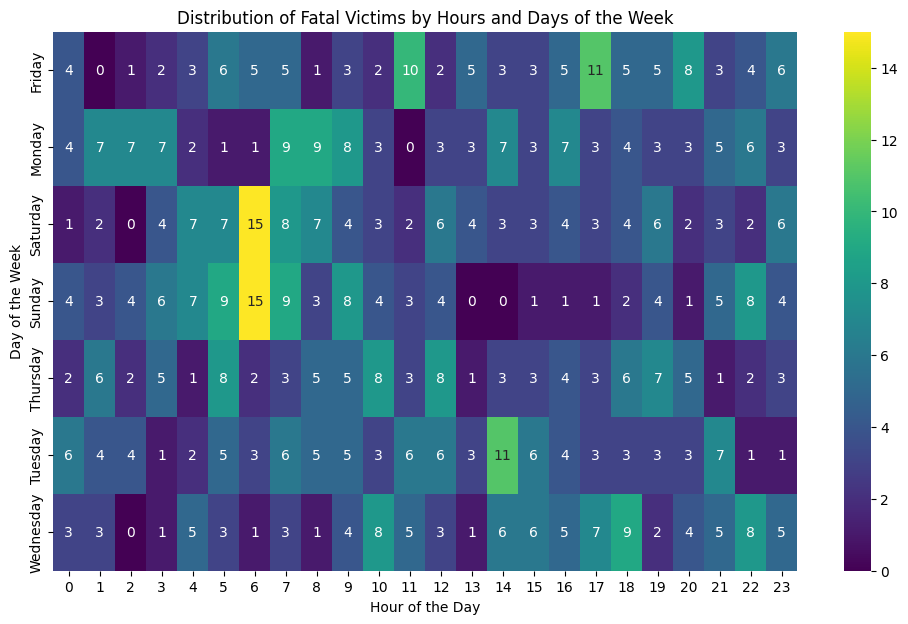

In [111]:
# We'll also need to convert 'Hora' (if it's not in 24-hour format) to extract the hour of the day.
homicidios['Fecha'] = pd.to_datetime(homicidios['Fecha'], errors='coerce')
homicidios['Day of the Week'] = homicidios['Fecha'].dt.day_name()

# Assuming 'Hora' is a string that represents the time of day, let's convert it to datetime and extract the hour.
# If 'Hora' is already an hour or is in HH:MM format, adjust the code accordingly.
homicidios['Hora'] = pd.to_datetime(homicidios['Hora'], format='%H:%M:%S', errors='coerce').dt.hour

# We can create a new DataFrame for the heatmap data using groupby and unstack.
# This will give us the number of incidents for each hour and day of the week.
heatmap_data = homicidios.groupby(['Day of the Week', 'Hora']).size().unstack(fill_value=0)

# Now we can plot the heatmap.
plt.figure(figsize=(12, 7))
sns.heatmap(heatmap_data, annot=True, fmt="d", cmap='viridis')
plt.title('Distribution of Fatal Victims by Hours and Days of the Week')
plt.xlabel('Hour of the Day')
plt.ylabel('Day of the Week')
plt.show()

The heatmap titled **"Distribution of Fatal Victims by Hours and Days of the Week"** indicates that weekends, especially early mornings on Saturdays and Sundays, see a higher number of fatal victims from 03:00 to 09:00. This trend is somewhat unexpected as it does not coincide with typical workday rush hours (05:00 - 09:00), midday (12:00 - 14:00), or evening commutes (17:00 - 18:00). Instead, the early morning hours on weekends appear to be particularly dangerous.

On weekdays, the frequency of incidents is lower during the early morning hours, suggesting less traffic-related danger. However, the weekend data reveals a concerning pattern: while there may be fewer incidents, those that occur tend to have more severe outcomes, which could be attributed to various factors, including reduced visibility or the influence of weekend social behaviors.

In summary, while rush hour periods on weekdays present expected spikes in traffic incidents, the early weekend mornings emerge as a critical time with a higher risk of fatalities. These insights are crucial for traffic safety authorities in Buenos Aires (CABA), highlighting the need for increased vigilance and possibly tailored safety campaigns during these peak risk times on weekends.

#### **Victims Age Range**

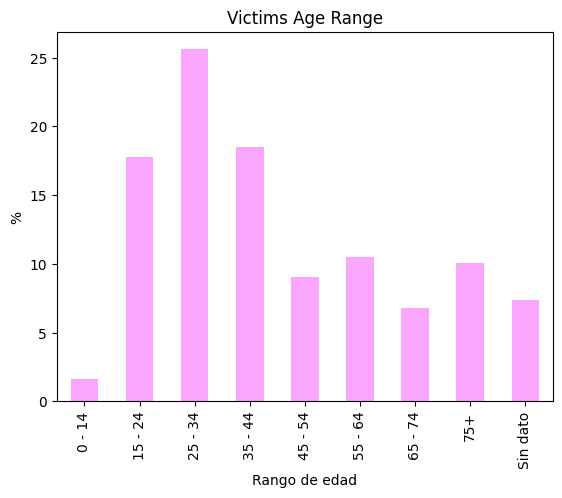

In [112]:
# Assuming you have a DataFrame named homicidios
homicidios['Edad'].replace('SD', np.nan, inplace=True)  # Replace 'SD' with NaN
homicidios['Edad'] = pd.to_numeric(homicidios['Edad'], errors='coerce')  # Convert age to numeric, set errors='coerce' to handle any conversion problems

# Define bins for age groups
bins = [0, 14, 24, 34, 44, 54, 64, 74, float('inf')]
labels = ['0 - 14', '15 - 24', '25 - 34', '35 - 44', '45 - 54', '55 - 64', '65 - 74', '75+']

# Create new column for age groups
homicidios['Rango de edad'] = pd.cut(homicidios['Edad'], bins=bins, labels=labels)

# Count values in each group including NaN (Sin dato)
age_counts = homicidios['Rango de edad'].value_counts(normalize=True) *100 
age_counts['Sin dato'] = homicidios['Rango de edad'].isna().sum() / len(homicidios) *100 

# Sort index 
age_counts.sort_index(inplace=True)

# Plotting the bar chart using the provided color.
age_counts.plot(kind='bar', color='#faa6ff')
plt.title('Victims Age Range')
plt.ylabel('%')
plt.show()

Analyzing traffic incidents in Buenos Aires, the data show that young adults, especially ages 15-34, are the most affected by traffic incidents, likely due to inexperience or risky driving. There's also a concern for the elderly, with a slight rise in incidents for those over 75. A notable gap in the data for ages (labeled as "Sin dato") could impact the effectiveness of safety measures. Targeted interventions for these age groups and improved data collection are essential for enhancing road safety in the city.

#### **Spatial distribution of incidents with victims Coordinates**

<Axes: >

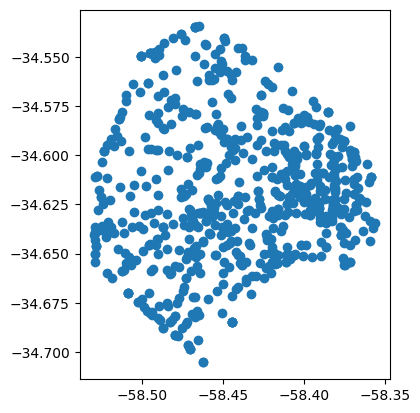

In [113]:
# Define the Coordinate Reference System (CRS)
crs = 'epsg:4326'

# Create a geometry by combining the "Pos x" and "Pos y" columns as Points
geometry = [Point(xy) for xy in zip(homicidios["Pos x"], homicidios["Pos y"])]

# Create a GeoDataFrame using the specified CRS and geometry
geodata = gpd.GeoDataFrame(homicidios, crs=crs, geometry=geometry)

# Plot the GeoDataFrame
geodata.plot()

Text(158.98305973900304, 0.5, 'Latitude')

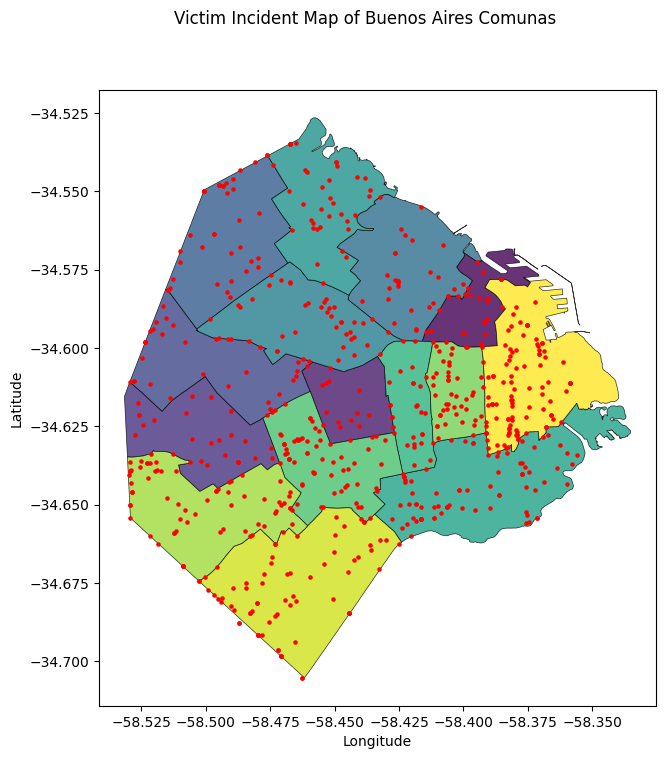

In [114]:
# Import the necessary libraries and set SHAPE_RESTORE_SHX to 'YES' to handle shapefile issues
with fiona.Env(SHAPE_RESTORE_SHX='YES'):
    # Read the shapefile for Buenos Aires Communes
    shp_file = gpd.read_file(r"./data/comunas_wgs84.shp")

# Create axes and figures for plotting
fig, ax = plt.subplots(figsize=(10, 8))

# Draw the Shapefile on the map of Buenos Aires Communes
shp_file.plot(ax=ax, facecolor='blue', edgecolor='k', alpha=0.8, linewidth=0.5, cmap="viridis")

# Draw the geospatial data points on the map
geodata.plot(ax=ax, color='red', markersize=5)

# Add title and axis labels
fig.suptitle('Victim Incident Map of Buenos Aires Comunas', fontsize=12)
ax.set_xlabel('Longitude', fontsize=10)
ax.set_ylabel('Latitude', fontsize='medium')

The victim incident map of Buenos Aires highlights a higher concentration of accidents in the eastern part of the city, particularly in Communes 1 and 4. These areas warrant targeted safety measures and increased awareness campaigns to mitigate the risk of further incidents.

## Check Outliers

We conduct a search for data with outliers in the features and analyze whether it is necessary to remove them.

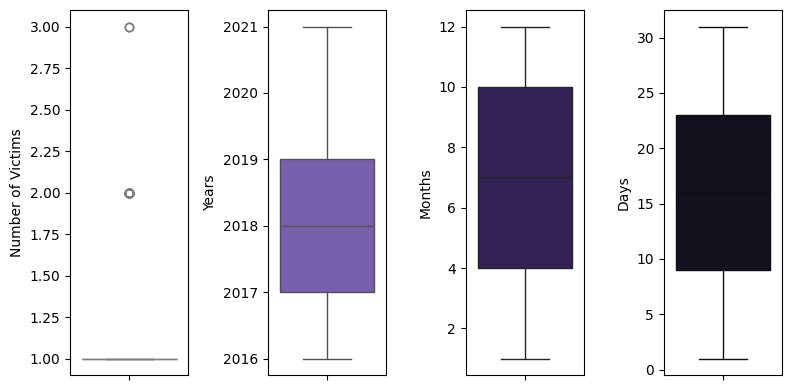

In [115]:
# Adjust the size of the figure
plt.figure(figsize=(10, 4))

# Create subplots for the charts
plt.subplot(1, 5, 1) 
sns.boxplot(data=homicidios, y='N victimas', color = "#faa6ff")
plt.ylabel('Number of Victims')

plt.subplot(1, 5, 2) 
sns.boxplot(data=homicidios, y='Año', color = "#7353ba")
plt.ylabel('Years')

plt.subplot(1, 5, 3) 
sns.boxplot(data=homicidios, y='Mes', color = "#2f195f")
plt.ylabel('Months')

plt.subplot(1, 5, 4) 
sns.boxplot(data=homicidios, y='Día', color = "#0f1020")
plt.ylabel('Days')

# Adjust spacing between subplots
plt.tight_layout()

# Display the plots
plt.show()

The provided graph contains three boxplots, which are used to display the distribution of quantitative data and to identify potential outliers. Here is an analysis of each:

1. **Number of Victims**:
   - This plot shows a distribution where most data points are close to the value of 1, indicating that the majority of recorded incidents have a single victim.
   - There are a few outliers above 2, suggesting there are some incidents with a higher number of victims.
   - The interquartile range (the height of the box) is very small, indicating that values are concentrated around the median.

2. **Years**:
   - The `Years` boxplot appears to be uniformly distributed from 2016 to 2021, indicating that the data are spread out over these years.
   - No outliers are visible, and the whiskers extend uniformly up and down from the box, suggesting no significant variation in the amount of data year over year.
   - The median line is roughly in the center of the box, suggesting a symmetric distribution of the data by year.

3. **Months**:
   - The `Months` plot shows a distribution with a median around 6, indicating that half of the incidents occurred before and the other half after June.
   - The interquartile range is wider compared to 'Number of Victims', indicating more spread in the data.
   - No outliers are present, and the whiskers suggest that incidents are registered throughout the entire year.

4. **Days**:
   - This plot shows that incidents are fairly evenly distributed throughout the days of the month.
   - The median is around the 15th day, which is expected if incidents are evenly spread.
   - The interquartile range is relatively wide, indicating a uniform dispersion across the days of the month.
   - No outliers are observed, suggesting there are no days with a significantly different number of incidents compared to the rest.

Overall, the charts suggest a relatively uniform distribution of incidents over the years, months, and days, with the exception of some outliers in the number of victims. Even though the outliers in the first plot are actually real and feasible.